### Requirements

- python 3.6.2

```python
conda install -c sebp scikit-survival
conda install -c anaconda seaborn
```
- numpy 1.15.4
- pandas 0.20.3
- scikit-learn 0.19.2
- scikit-survival 0.6.0
- seaborn 0.9.0


In [180]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. load data

In [2]:
df = pd.read_csv("employee_retention_data.csv")

#### Data Example

- employee_id : id of the employee. Unique by employee per company 
- company_id : company id. 
- dept : employee dept 
- seniority : number of yrs of work experience when hired 
- salary: avg yearly salary of the employee during her tenure within the company 
- join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13 
- quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

In [3]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


#### Check Missing Data
- no missing data
- NAN in join_date: still employed by 2015/12/13

In [14]:
df.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

#### Data Size

In [15]:
df.shape

(24702, 7)

#### Censored Date
people didn't quit

In [153]:
sum(df["quit_date"].isnull())

11192

## 2. Exploratory Analysis: distribution

#### Distribution of company
- 34% data from one company

(array([0.34353494, 0.17091733, 0.11128654, 0.08347502, 0.07104688,
        0.05226297, 0.04955064, 0.04238523, 0.03890373, 0.03501741,
        0.00064772, 0.00097158]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 12 Patch objects>)

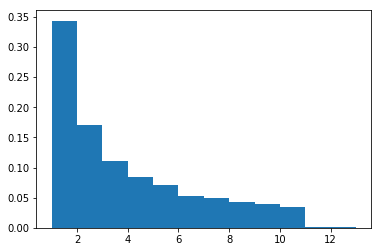

In [29]:
plt.hist(df["company_id"], density = True, bins = range(1,14))

#### Distribution of company

(array([0.44595579, 0.15496721, 0.06703911, 0.22409521, 0.15384989,
        0.15409279]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <a list of 6 Patch objects>)

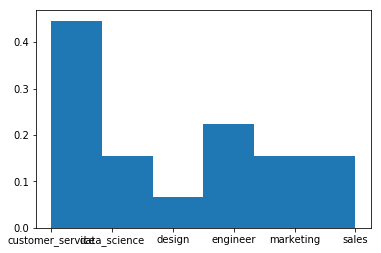

In [43]:
plt.hist(df["dept"], density = True, bins = 6)

#### Distribution of salary
- left skewed

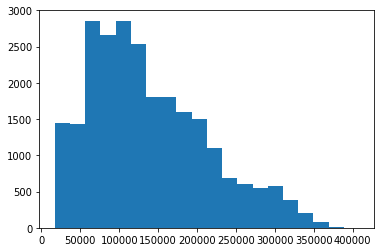

In [33]:
plt.hist(df["salary"], bins = 20)
plt.show()

## 3. Exploratory Analysis: quit time trend

In [36]:
df['quit_date'] = pd.to_datetime(df['quit_date'])

Text(0.5,1,'quit time by year')

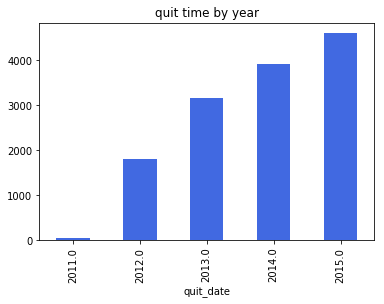

In [48]:
df['quit_date'].groupby(df["quit_date"].dt.year).count().plot(kind="bar", color = "royalblue")
plt.title("quit time by year")

Text(0.5,1,'quit time by month')

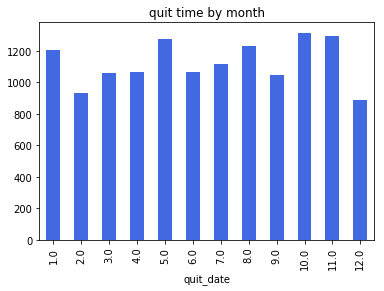

In [49]:
df['quit_date'].groupby(df["quit_date"].dt.month).count().plot(kind="bar", color = "royalblue")
plt.title("quit time by month")

## 4. survival analysis: feature engineer

#### df_y
- "status": True if quit
- survival_days: days between join and quit

In [129]:
df["status"] = df["quit_date"].notnull()

In [130]:
df['quit_date'] = pd.to_datetime(df['quit_date'])
df['join_date'] = pd.to_datetime(df['join_date'])

In [131]:
df["survival_days"] = (df["quit_date"] - df["join_date"]).dt.days

In [132]:
df_y = pd.DataFrame({"status": df["status"],
                     "survival_days": df["survival_days"]})

In [133]:
### survival time for people who haven't quit
df_y["survival_days"] = df_y["survival_days"].fillna((pd.Timestamp("2015/12/13 ") - pd.Timestamp("2011/01/24")).days)

In [155]:
df_y.head()

,status,survival_days
0,True,585.0
1,True,340.0
2,False,1784.0
3,True,389.0
4,True,1040.0


In [156]:
df_y_array = df_y.to_records(index = False)

#### df_x

- numeric: standardize
- categorical: one hot coding

In [157]:
df.columns

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date', 'status', 'survival_days'],
      dtype='object')

In [158]:
df_x = df[['company_id', 'dept', 'seniority', 'salary']]

In [159]:
df_x['company_id'] = df_x['company_id'].astype('category')
df_x['dept'] = df_x['dept'].astype('category')

/anaconda3/envs/datachallenge/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/datachallenge/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [160]:
from sksurv.preprocessing import OneHotEncoder

df_x_numeric = OneHotEncoder().fit_transform(df_x)
df_x_numeric.head()

,company_id=2,company_id=3,company_id=4,company_id=5,company_id=6,company_id=7,company_id=8,company_id=9,company_id=10,company_id=11,company_id=12,dept=data_science,dept=design,dept=engineer,dept=marketing,dept=sales,seniority,salary
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,89000.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20,183000.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14,101000.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,115000.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23,276000.0


#### train, test split

In [163]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x_numeric, df_y_array, test_size=0.3, random_state=12345)

## 5. survival analysis: linear model
Cox's proportional hazard's model

In [175]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train[["seniority","salary"]])
x_train[["seniority","salary"]] = scaler.transform(x_train[["seniority","salary"]])

/anaconda3/envs/datachallenge/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/envs/datachallenge/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [177]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(x_train, y_train)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=0)

#### test accuracy

In [181]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_test[["seniority","salary"]])
x_test[["seniority","salary"]] = scaler.transform(x_test[["seniority","salary"]])

estimator.score(x_test, y_test)

0.5315675588784463

#### feature importance:

In [178]:
pd.Series(estimator.coef_, index=df_x_numeric.columns)

company_id=2        -0.065035
company_id=3        -0.025978
company_id=4        -0.029906
company_id=5        -0.020329
company_id=6        -0.009395
company_id=7        -0.020661
company_id=8        -0.016979
company_id=9        -0.014120
company_id=10       -0.015942
company_id=11        0.561809
company_id=12       -0.112707
dept=data_science    0.111306
dept=design          0.112633
dept=engineer        0.057794
dept=marketing       0.112034
dept=sales           0.153454
seniority            0.059639
salary              -0.102682
dtype: float64